In [1]:
# !pip install node2vec

In [2]:
# !pip install gensim -- upgrade

# preprocessing

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

In [4]:
# na_filter = False is for not read "NA" as null value

node_data = pd.read_csv("jean-complete-node.csv",na_filter = False)
node_data

,Id,Label,Description
0,TH,Thénardier,"Thénardier, innkeeper in Montfermeil, aka Jond..."
1,TG,Théodule,"Lieutenant Théodule Gillenormand, grandnephew ..."
2,TE,German teamster,German teamster
3,TC,Three concierges,"Three concierges, met by Gvaroche"
4,GV,Government troops,Government troops
...,...,...,...
176,HL,Mme Hucheloup,"Mme Hucheloup, keeper of Corinth Inn"
177,TS,Toussaint,"Toussaint, servant of Valjean at Rue Plumet"
178,TR,Three gendarmes,"Three gendarmes, arrested Valjean"
179,HD,Hospital director,Hospital director in Digne


In [5]:
edge_data = pd.read_csv("jean-complete-edge.csv",na_filter = False)
edge_data

,Source,Target,Type,Id,Label
0,MY,NP,Undirected,1,1.1.1
1,MB,MY,Undirected,2,1.1.1
2,ME,MY,Undirected,3,1.1.1
3,MB,ME,Undirected,4,1.1.1
4,HD,MY,Undirected,5,1.1.2
...,...,...,...,...,...
1584,CO,JV,Undirected,1585,5.9.5
1585,JV,MA,Undirected,1586,5.9.5
1586,CO,MA,Undirected,1587,5.9.5
1587,DJ,MA,Undirected,1588,5.9.5


In [6]:
node_data[node_data["Id"] =='NA'].index

Int64Index([121], dtype='int64')

In [7]:
len(edge_data)

1589

In [8]:
edge_data[edge_data["Source"] == np.nan].index

Int64Index([], dtype='int64')

In [9]:
edge_data[edge_data["Source"] =='NA'].index

Int64Index([], dtype='int64')

In [10]:
edge_data[edge_data["Target"] =='NA'].index

Int64Index([1096], dtype='int64')

In [11]:
edge_data[edge_data["Target"] == np.nan].index

Int64Index([], dtype='int64')

In [12]:
edge_data['Target'].iloc[1096]

'NA'

In [13]:
node_list = []

for i in range(len(node_data)):
    node_list.append(node_data['Id'][i])
    
edge_list = []

for i in range(len(edge_data)):
    edge_list.append((edge_data['Source'][i],edge_data['Target'][i]))

In [14]:
np.nan in node_list

False

In [15]:
'NA' in node_list

True

In [16]:
np.nan in edge_list

False

In [17]:
G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(edge_list)

nan_nodes = []
for node in G.nodes():
    if node == np.nan:
        nan_nodes.append(node)
G.remove_nodes_from(nan_nodes)

In [18]:
G

In [19]:
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

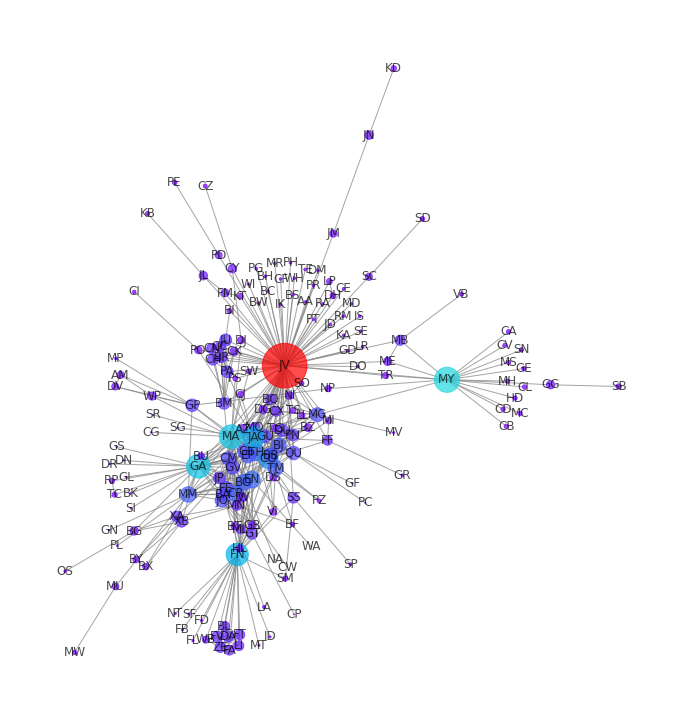

In [20]:
plt.figure(figsize=(12,13))
plt.axis('off')
nx.draw_networkx(G, node_size=nsize, alpha = 0.7, node_color = list(pr.values()),edge_color = '.5', cmap=plt.cm.rainbow)

In [21]:
len(G.nodes)

181

In [22]:
np.nan in set(G.nodes)

False

# hyper parameter p = 1, q = 0.0001

In [23]:
from node2vec import Node2Vec

node2vec1 = Node2Vec(graph=G, # target graph
                    dimensions=50, # embedding dimension
                    walk_length=10, # number of nodes in each walks 
                    p = 1, # return hyper parameter
                    q = 0.0001, # inout parameter, q값을 작게 하면 structural equivalence를 강조하는 형태로 학습됩니다. 
                    weight_key=None, # if weight_key in attrdict 
                    num_walks=2000, 
                    workers=1,
                   )

C:\Users\wjdwodnjs302\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Computing transition probabilities:   0%|          | 0/181 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 137.15it/s]


In [25]:
for i, each_walk in enumerate(node2vec1.walks):
    print(f"{i:0>2d}, {each_walk}")
    if i>1:
        break

00, ['GT', 'BO', 'CO', 'EP', 'GU', 'PN', 'BZ', 'PN', 'JA', 'CJ']
01, ['FL', 'FN', 'FV', 'BL', 'FA', 'DA', 'WB', 'ZE', 'FA', 'DA']
02, ['GE', 'MY', 'MG', 'NI', 'GI', 'MA', 'SR', 'MA', 'JA', 'TM']


In [26]:
model1 = node2vec1.fit(window=2)

In [27]:
# kmeans clustering을 진행해줍니다. 
from sklearn.cluster import KMeans

K = 3
kmeans = KMeans(n_clusters=K, random_state=0).fit(model1.wv.vectors)
# node의 cluster 부분을 attrdict에 업데이트해줍니다. 
for n, label in zip(model1.wv.index_to_key, kmeans.labels_):
    G.nodes[n]['label'] = label

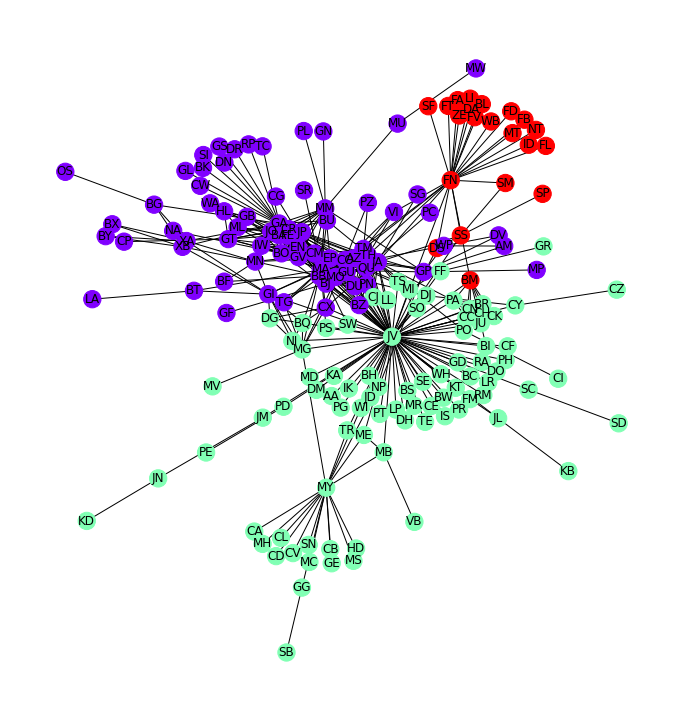

In [28]:
plt.figure(figsize=(12, 13))
nx.draw_networkx(G, pos=nx.layout.spring_layout(G), 
                 node_color=[n[1]['label'] for n in G.nodes(data=True)], 
                 cmap=plt.cm.rainbow
                )
plt.axis('off')
plt.show()

# hyper parameter p = 1, q = 2

In [29]:
from node2vec import Node2Vec

node2vec2 = Node2Vec(graph=G, # target graph
                    dimensions=50, # embedding dimension
                    walk_length=10, # number of nodes in each walks 
                    p = 1, # return hyper parameter
                    q = 2, # inout parameter, q값을 작게 하면 structural equivalence를 강조하는 형태로 학습됩니다. 
                    weight_key=None, # if weight_key in attrdict 
                    num_walks=2000, 
                    workers=1,
                   )

Computing transition probabilities:   0%|          | 0/181 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 140.09it/s]


In [31]:
for i, each_walk in enumerate(node2vec2.walks):
    print(f"{i:0>2d}, {each_walk}")
    if i>1:
        break

00, ['BO', 'JP', 'BO', 'MA', 'JO', 'GV', 'GA', 'MA', 'CX', 'DG']
01, ['WA', 'EN', 'MA', 'CJ', 'JA', 'MA', 'GA', 'BA', 'EN', 'GA']
02, ['AA', 'JV', 'NI', 'JV', 'MB', 'ME', 'MY', 'CB', 'MY', 'MH']


In [32]:
model2 = node2vec2.fit(window=2)

In [33]:
# kmeans clustering을 진행해줍니다. 
from sklearn.cluster import KMeans

K = 3
kmeans = KMeans(n_clusters=K, random_state=0).fit(model2.wv.vectors)
# node의 cluster 부분을 attrdict에 업데이트해줍니다. 
for n, label in zip(model1.wv.index_to_key, kmeans.labels_):
    G.nodes[n]['label'] = label

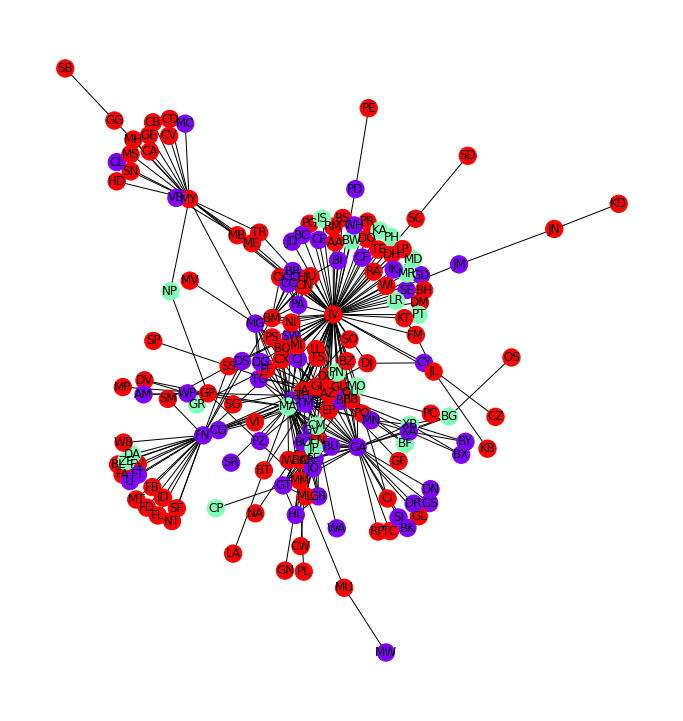

In [34]:
plt.figure(figsize=(12, 13))
nx.draw_networkx(G, pos=nx.layout.spring_layout(G), 
                 node_color=[n[1]['label'] for n in G.nodes(data=True)], 
                 cmap=plt.cm.rainbow
                )
plt.axis('off')
plt.show()